In [36]:
import re

from Bio import SeqIO
from Bio import AlignIO
from Bio.Align import MultipleSeqAlignment
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from tqdm import tqdm  # 用于显示进度条

import subprocess

In [2]:
alignment = AlignIO.read("../data/roary_result/core_gene_alignment.aln", "fasta")

In [3]:
# 将比对对象转换为 NumPy 数组以便于矩阵操作（加速计算）
alignment_array = np.array([list(record.seq) for record in alignment])

# 获取总序列数和比对长度
num_sequences, alignment_length = alignment_array.shape

# 定义 gap 碱基集合
gap_bases = {"-", ".", "N"}

# 使用矩阵操作计算每列非 gap 的比例
non_gap_counts = np.sum(~np.isin(alignment_array, list(gap_bases)), axis=0)
non_gap_ratios = non_gap_counts / num_sequences

In [4]:
# 计算分位数
quantiles = np.quantile(non_gap_ratios, [0.25, 0.5, 0.75])
quantiles

array([0.99764706, 0.99882353, 1.        ])

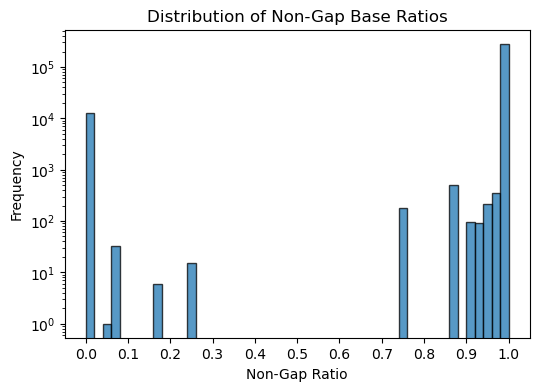

In [5]:
plt.figure(figsize = (6, 4))
plt.hist(non_gap_ratios, bins = np.arange(0, 1.02, 0.02), alpha = 0.75, edgecolor = "black")
plt.title("Distribution of Non-Gap Base Ratios")
plt.xlabel("Non-Gap Ratio")
plt.ylabel("Frequency")
# 设置纵轴为对数坐标
plt.yscale("log")
# 修改 x 轴刻度和标签
plt.xticks(ticks=np.arange(0, 1.1, 0.1), labels=[f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)])
plt.show()

In [6]:
np.sum(non_gap_ratios < 0.99) / len(non_gap_ratios)

0.051881101608052024

In [7]:
np.sum(non_gap_ratios < 0.99)

15438

In [8]:
len(non_gap_ratios)

297565

In [9]:
LEN_GAP_FILTER = 2

# 初始化一个集合，用于存储所有位置的并集
gap_positions_union = set()

# 遍历每条序列
for record in tqdm(alignment, desc = "Processing sequences"):
    sequence = str(record.seq)  # 转换为字符串
    gap_start = None  # 用于记录 gap 段的起始位置

    # 遍历序列中的每个字符及其索引
    for i, char in enumerate(sequence):
        if char == "-":  # 当前字符是 gap
            if gap_start is None:
                gap_start = i  # 记录 gap 起始位置
        else:  # 当前字符不是 gap
            if gap_start is not None and i - gap_start >= LEN_GAP_FILTER:
                # 记录连续 5 个或以上 gap 的位置
                gap_positions_union.update(range(gap_start, i))
            gap_start = None  # 重置 gap 起始位置

    # 处理序列末尾连续 gap 的情况
    if gap_start is not None and len(sequence) - gap_start >= LEN_GAP_FILTER:
        gap_positions_union.update(range(gap_start, len(sequence)))

# 输出所有位置的并集
gap_positions_union = sorted(gap_positions_union)  # 可选：排序方便查看

Processing sequences: 100%|██████████████████████████████████████████████████████| 850/850 [00:14<00:00, 56.81it/s]


In [10]:
len(gap_positions_union)

166243

In [11]:
len(gap_positions_union) / len(non_gap_ratios)

0.5586779359131618

In [12]:
gap_positions_non_gap_ratios = [non_gap_ratios[i] for i in gap_positions_union]

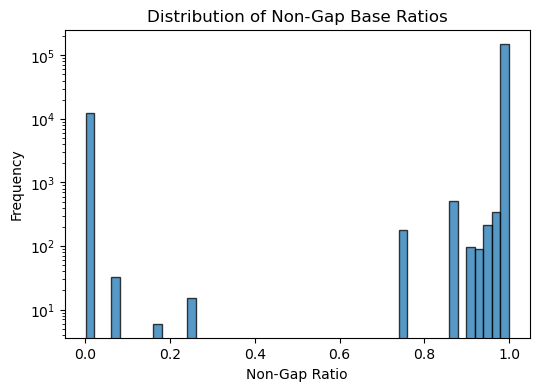

In [13]:
plt.figure(figsize = (6, 4))
plt.hist(gap_positions_non_gap_ratios, bins = 50, alpha = 0.75, edgecolor = "black")
plt.title("Distribution of Non-Gap Base Ratios")
plt.xlabel("Non-Gap Ratio")
plt.ylabel("Frequency")
# 设置纵轴为对数坐标
plt.yscale("log")
# 修改 x 轴刻度和标签
# plt.xticks(ticks=np.arange(0, 1.1, 0.1), labels=[f"{x:.1f}" for x in np.arange(0, 1.1, 0.1)])
plt.show()

In [15]:
# 计算要保留的位置集合
positions_to_keep = sorted(set(range(alignment.get_alignment_length())) - set(gap_positions_union))
len(positions_to_keep)

131322

In [19]:
# 提取需要的列
filtered_records = []
for record in tqdm(alignment, desc = "Processing sequences"):
    sequence_array = np.array(list(str(record.seq)))  # 转换为 NumPy 数组
    filtered_sequence = "".join(sequence_array.take(positions_to_keep))  # 按列索引提取
    filtered_records.append(SeqRecord(Seq(filtered_sequence), id=record.id, description=record.description))

# 构建新的 MultipleSeqAlignment
filtered_alignment = MultipleSeqAlignment(filtered_records)

Processing sequences: 100%|██████████████████████████████████████████████████████| 850/850 [00:26<00:00, 31.54it/s]


In [24]:
filtered_alignment

<<class 'Bio.Align.MultipleSeqAlignment'> instance (850 records of length 131322) at 78a31f468610>

In [26]:
AlignIO.write(filtered_alignment, "../data/core_genes_removed_gap/core_gene_alignment_filtered.aln", "fasta")

1

In [30]:
with open('../data/core_genes_removed_gap/core_gene_snp_filtered.aln', 'w') as output_file:
    subprocess.run([
        'snp-sites', 
        '../data/core_genes_removed_gap/core_gene_alignment_filtered.aln'
    ], stdout = output_file, text = True)

In [ ]:
# 使用 core_gene_alignment_filtered.aln 取 unique 保留 296 条序列
# 使用 core_gene_snp_filtered.aln       取 unique 保留 287 条序列
# snp-sites 过滤掉了部分位点 

In [55]:
snp_alignment = AlignIO.read('../data/core_genes_removed_gap/core_gene_snp_filtered.aln', 'fasta')
alignment_dict = SeqIO.to_dict(snp_alignment)

In [56]:
repeat_seqname = []
target_seqname = []
unique_seq_list = []
for seq_name, seq_records in alignment_dict.items():
    if len(unique_seq_list) == 0:
        unique_seq_list.append(seq_records)
    else:
        FLAG = True
        for seq in unique_seq_list:
            if seq_records.seq == seq.seq:
                FLAG = False
                repeat_seqname.append(seq_name)
                target_seqname.append(seq.id)
                break
        if FLAG:
            unique_seq_list.append(seq_records)

In [57]:
SeqIO.write(unique_seq_list, "../data/core_genes_removed_gap/core_gene_snp_filtered_unique.aln", "fasta")

287

In [58]:
repeat_info = pd.DataFrame({'repeat_seqname': repeat_seqname, 'target_seqname': target_seqname})
repeat_info.to_csv("../data/core_genes_removed_gap/core_gene_alignment_repeat.csv", sep = ",", index = False, header = True)